<a href="https://colab.research.google.com/github/andy-j-block/lymphoma_classifier/blob/master/Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/andy-j-block/lymphoma_classifier/blob/master/Classifier.ipynb)

#TODO:
- Visualize nested k-fold sets

# Background

This project is a multiclass classification of three different types of lymphoma: 

- chronic lymphocytic leukemia (CLL)
- follicular lymphoma (FL) 
- mantle cell lymphoma (MCL)

I was diagnosed with Hodgkin's Lymphoma myself back in 2013 so this project has a special personal relevance to me.

The dataset that will be utilized throughout this project is 374 immunostained biopsy images of the three different subtypes of lymphoma.  The data itself can be found [here](https://www.kaggle.com/andrewmvd/malignant-lymphoma-classification).  Credit to the authors of the dataset:

> Orlov, Nikita & Chen, Wayne & Eckley, David & Macura, Tomasz & Shamir, Lior & Jaffe, Elaine & Goldberg, Ilya. (2010). Automatic Classification of Lymphoma Images With Transform-Based Global Features. IEEE transactions on information technology in biomedicine : a publication of the IEEE Engineering in Medicine and Biology Society. 14. 1003-13. 10.1109/TITB.2010.2050695.

#Results

# Setup and Data Import
This first section will comprise of four different tasks:

- determining whether the user is utilizing a hosted or local runtime
- importing the data from GitHub
- opening each image using Pillow and formatting them as an array in NumPy
- storing the image data in a Pandas DataFrame

The additional task of downloading the latest version of the albumentations library will also be performed in this step if the user is utilizing a hosted runtime.  That way, if the kernel needs to be restarted to incorporate this change, it is done towards the beginning of the script.



###Imports and function definitions

In [1]:
from PIL import Image
import os
from matplotlib import pyplot as plt
from os.path import abspath
import numpy as np
import pandas as pd
import random
import gc

In [2]:
def running_hosted():

    if 'content' in os.getcwd():
        hosted = True
      
    else:
        hosted = False
        %autosave 120
    
    if hosted:
       print(f'This notebook is running hosted') 
    
    else:
        print(f'This notebook is running locally\nAutosave is set to 120 seconds')

    return hosted

############

def colab_setup():

    %cd -q /content/
    
    #check if git clone already performed
    if not os.path.isdir('./lymphoma_classifier'):
        !git clone https://github.com/andy-j-block/lymphoma_classifier.git
        
    %cd -q /content/lymphoma_classifier
    current_dir = os.getcwd()
    print(f"Current directory is '{current_dir}'")


############      

def load_images(imgs_main_dir):
    
    # get cancer type strings
    cancer_types = [type_ for type_ in os.listdir(imgs_main_dir)]

    # get directories where images are stored
    img_dirs = [os.path.join(imgs_main_dir, type_) for type_ in cancer_types]
    
    # read images into a list
    imgs = []

    for i, img_dir in enumerate(img_dirs):       
        img_paths = os.listdir(img_dir)
        
        for j in img_paths:

            # pass thru all the image files per image directory, read the image,
            # add it to the images list
            img_path = os.path.join(img_dirs[i], j)
            img_array = Image.open(img_path)
            img_array = np.asarray(img_array)        
            imgs.append((cancer_types[i], img_array))
                
    return imgs

###Local or hosted runtime

I like to use Google Colab for its hosted runtime features so I include a check to see if the notebook is being run locally or hosted.

In [3]:
hosted = running_hosted()

This notebook is running hosted


If the notebook is being run from a hosted runtime, the Git repo is cloned into the working directory.  Otherwise, it is assumed that the user has cloned the original Git repo and the dataset is saved on their machine.

In [4]:
if hosted:
    colab_setup()

Cloning into 'lymphoma_classifier'...
remote: Enumerating objects: 601, done.
remote: Counting objects: 100% (185/185), done.
remote: Compressing objects: 100% (184/184), done.
remote: Total 601 (delta 87), reused 3 (delta 1), pack-reused 416
Receiving objects: 100% (601/601), 1.47 GiB | 33.14 MiB/s, done.
Resolving deltas: 100% (104/104), done.
Checking out files: 100% (380/380), done.
Current directory is '/content/lymphoma_classifier'


For whatever reason, the default installed version of the Albumentations library on Google Colab is a very outdated one.  Fetching the latest version of albumentations library if running on hosted machine.

In [5]:
if hosted:
    !pip install albumentations --upgrade -q
    !pip install sklearn --upgrade -q

     |████████████████████████████████| 102kB 8.4MB/s 
     |████████████████████████████████| 38.2MB 79kB/s 


###Data import and image preview

The images will now be imported and saved in an object.  As a sanity check, display the first image label, the first few entries of the first image array, and then show the first image in a manageable reduced size.

First entry cancer type: CLL

First entry image array: [[[143 138 145]
  [154 138 144]
  [152 139 148]
  ...
  [164 157 158]
  [156 151 156]
  [148 145 154]]

 [[140 138 147]
  [147 138 146]
  [143 139 150]
  ...
  [157 157 162]
  [152 151 158]
  [145 145 154]]

 [[124 123 138]
  [125 123 140]
  [121 121 140]
  ...
  [131 136 150]
  [132 136 147]
  [137 139 148]]]
continued...

First entry image:


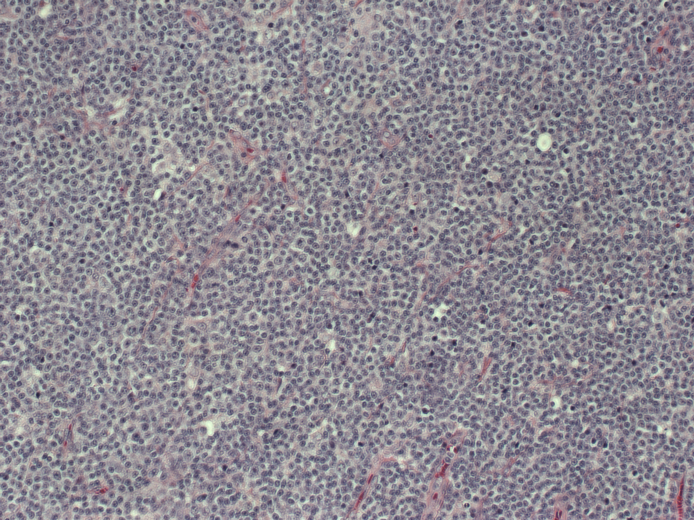

In [6]:
imgs = load_images('./Images')
print(f'First entry cancer type: {imgs[0][0]}\n')
print(f'First entry image array: {imgs[0][1][:3]}\ncontinued...\n')
print('First entry image:')
Image.fromarray(imgs[0][1]).reduce(2)

###Create DataFrame

Create a pandas dataframe object and confirm its shape.

In [7]:
df = pd.DataFrame(imgs, columns=['cancer_type', 'img_array'])
df.head(3)

,cancer_type,img_array
0,CLL,"[[[143, 138, 145], [154, 138, 144], [152, 139,..."
1,CLL,"[[[156, 148, 156], [158, 148, 158], [153, 141,..."
2,CLL,"[[[133, 136, 140], [134, 136, 141], [133, 136,..."


In [8]:
print(df.shape)

(374, 2)


# Exploratory Data Analysis

Given that these images are rich in latent features and confined to a low number of labels, the exploratory data analysis here is not substantial, as the model itself is going to be doing most of the work.  Class distribution will be explored, as well as ensuring that the images are all the same size and their RGB arrays are within the expected intensity range of [0, 255].  The target column will be label encoded and a random sample of each of the cancer types will be shown in full image form.

###Imports and function definitions

In [9]:
import pandas as pd
import torch
import matplotlib.pyplot as plt
from scipy.special import binom
import seaborn as sns

In [10]:
def show_value_counts(series):

    print(f'The value counts are:\n{series.value_counts()}')

    percentages = [i/len(df) for i in series.value_counts().values]
    percentages = [round(i,2) for i in percentages]

    fig, ax = plt.subplots(1,1,figsize=(10,5))

    bar_chart=ax.bar(x=series.value_counts().index, 
                    height=series.value_counts().values)

    def add_labels(bar_chart, text_labels):
        for i, bar in enumerate(bar_chart):
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                    text_labels[i],
                    ha='center', va='bottom')
            
    add_labels(bar_chart, percentages)

    plt.title('Count by cancer type with percentages as text')
    plt.show()


############


def get_image_dims(data, set_=True):

    img_heights = []
    img_widths = []

    # widths and heights if input is pandas series 
    if type(data) is pd.Series:

        for i, _ in enumerate(data):
            img = data.iloc[i]
            height, width = img.shape[0], img.shape[1]
            img_heights.append(height)
            img_widths.append(width)

        if set_:
            # cast to set to eliminate duplicates
            img_heights = set(img_heights)
            img_widths = set(img_widths)
                
            print('Image heights are: ', img_heights)
            print('Image widths are: ', img_widths)
    
    # widths and heights if input is torchvision dataset
    else:

        for i in range(len(data)):
            width, height = data[i][0].shape[2], data[i][0].shape[1]
            img_heights.append(height)
            img_widths.append(width)

        # cast to set to eliminate duplicates
        img_heights = set(img_heights)
        img_widths = set(img_widths)
            
        print('Image heights are: ', img_heights)
        print('Image widths are: ', img_widths)

    if not set_:
        img_heights = min(img_heights)
        img_widths = min(img_widths)

    return img_heights, img_widths


############


def get_intensity_range(data):

    maxs = []
    mins = []

    # intesities if input is pandas series
    if type(data) is pd.Series:

        for i, _ in enumerate(data):
            maxs.append(np.amax(data.values[i]))
            mins.append(np.amin(data.values[i]))

    # intensities if input is torchvision dataset
    else:

        for i in range(len(data)):
            maxs.append(torch.max(data[i][0]))
            mins.append(torch.min(data[i][0])) 

    print(f'The highest intesity in the range: {max(maxs)}')
    print(f'The lowest intesity in the range: {min(mins)}')


############


def get_random_image(data, decode_dict, figsize=(30,10)):

    rand_imgs = []
    rand_idxs = []

    if type(data) is pd.DataFrame:
        for i in range(3):
            data_by_type = data[data['cancer_type']==i]
            rand_img = random.choice(data_by_type['img_array'].values)
            rand_imgs.append(rand_img)

        fig, axs = plt.subplots(1, len(rand_imgs), figsize=figsize)

        for i, img in enumerate(rand_imgs):
            axs[i].set_title(f'Cancer type: {decode_dict[i]}')
            axs[i].imshow(img)

    else:

        for _ in range(4):
            
            # get random index and store for later
            data_idxs = range(len(data))
            rand_idx = random.choice(data_idxs)
            rand_idxs.append(rand_idx)
            
            # get image with random index and convert RGB array back to image
            rand_img = data[rand_idx][0]
            rand_img = rand_img.permute(1, 2, 0)
            rand_imgs.append(rand_img)

        fig, axs = plt.subplots(1, 4, figsize=figsize)

        for i, img in enumerate(rand_imgs):
            axs[i].set_title(f'Cancer type: {decode_dict[int(data[rand_idxs[i]][1])]}')
            axs[i].imshow(img)


#################


def plot_prob_transforms(probabilities, n_poss_transforms):

    prob_dict = {}
    n_probabilities = len(probabilities)

    # define probabilities of specific number of transforms
    for p in probabilities:
        p_comp = 1-p
        prob_dict[p] = {i:p**i * p_comp**(n_poss_transforms-i) * binom(n_poss_transforms, i) \
                        for i in range(n_poss_transforms+1)}
    
    # pareto chart
    fig, axs = plt.subplots(1,len(probabilities), figsize=(30,10))
    fig.suptitle('Probability of a given number of transforms with varying p values')
    sns.set_style('dark')
    
    axes = {i:axs for (i, axs) in enumerate(axs)} # define dual axes dict
    for i, ax in enumerate(axs):
        axes[i+n_probabilities]=ax.twinx()
        axes[i+n_probabilities].set_ylim(0,1.05)

    for i, p in enumerate(probabilities):
        keys = list(prob_dict[p].keys())
        values = [prob_dict[p][k] for k in keys]
        
        sns.barplot(x=keys, y=values, ax=axes[i])
        axes[i].set_title(f'p={p}')

        cumulative_values = np.cumsum(values)
        sns.lineplot(x=keys, y=cumulative_values, ax=axes[i+n_probabilities], color='black', marker='o', markersize=10, linewidth = 3)

    return axes

###Class distribution and Label Encoding

Let's check the count of each cancer type and label encode them.

The value counts are:
FL     139
MCL    122
CLL    113
Name: cancer_type, dtype: int64


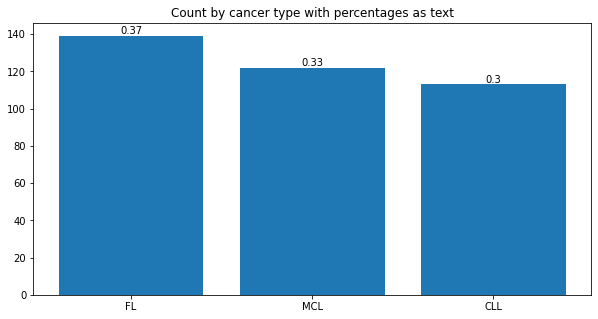

In [11]:
show_value_counts(df['cancer_type'])

In [12]:
encode_dict = {'CLL':0, 'FL':1, 'MCL':2}
decode_dict = {0: 'CLL', 1: 'FL', 2: 'MCL'}
df['cancer_type']=df['cancer_type'].replace(encode_dict)
df['cancer_type'].value_counts()

1    139
2    122
0    113
Name: cancer_type, dtype: int64

###Image size and color intensity

Check the image heights, widths, and color intensities to ensure uniform input dimensionality.

In [13]:
img_heights, img_widths = get_image_dims(df['img_array'])
img_heights_int, img_widths_int = get_image_dims(df['img_array'], set_=False)

Image heights are:  {1040}
Image widths are:  {1388}


In [14]:
get_intensity_range(df['img_array'])

The highest intesity in the range: 255
The lowest intesity in the range: 2


###Sample images

Let's look at a random image of each cancer type.

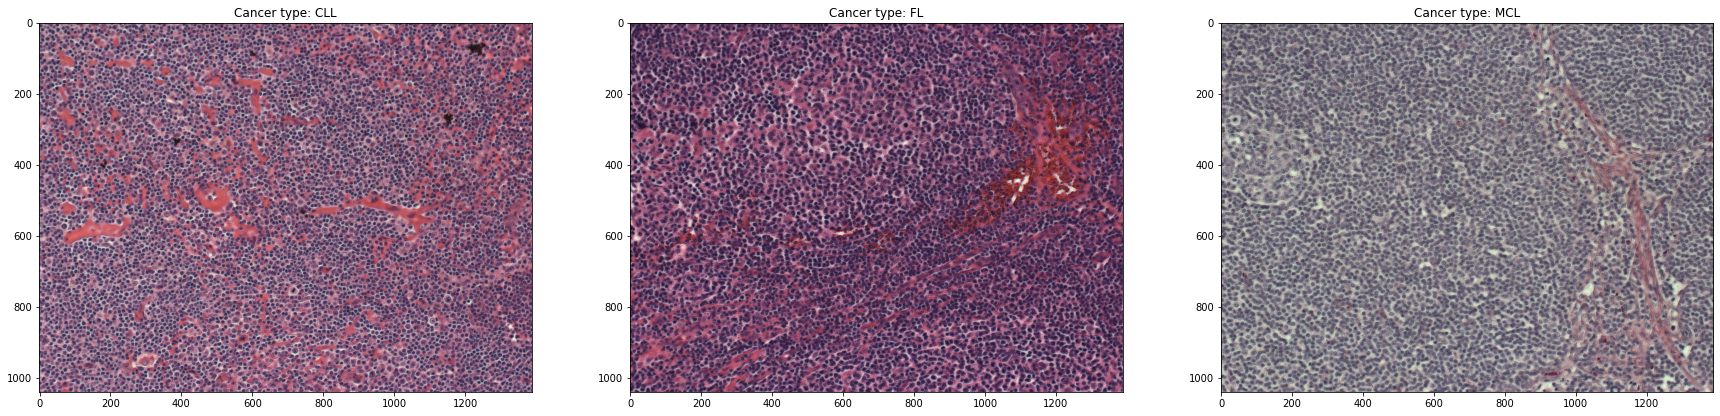

In [15]:
get_random_image(df, decode_dict)

###Plot transform probabilities

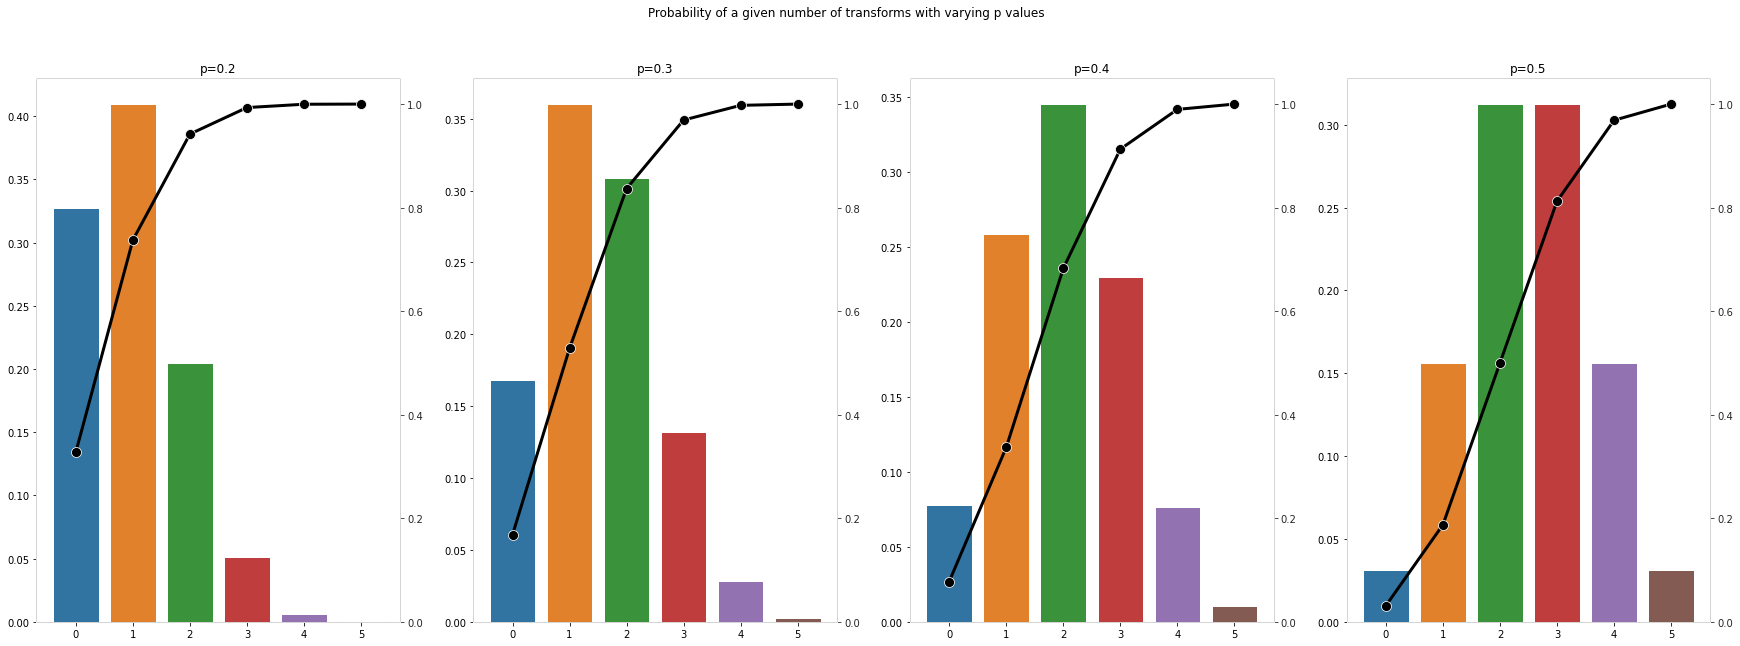

In [16]:
axes = plot_prob_transforms(probabilities=[0.2,0.3,0.4,0.5], n_poss_transforms=5)

# Prepare Data

###Imports and function definitions

In [17]:
from sklearn.model_selection import KFold

In [18]:
def visualize_sets(full_series, train_series, test_series, titles):

    series = [full_series, train_series, test_series]

    percentages = []
    
    for i, series_ in enumerate(series):

        percentage = [j/len(series_) for j in series_.value_counts().values]
        percentage = [round(j,2) for j in percentage]
        percentages.append(percentage)

    fig, ax = plt.subplots(1,len(series),figsize=(20,5))

    dfs=[]

    for i, series_ in enumerate(series):

        df = ax[i].bar(x=series_.value_counts().index, 
                    height=series_.value_counts().values)
        
        dfs.append(df)

    # Grabbed from matplotlib documentation:
    # https://matplotlib.org/2.0.2/examples/api/barchart_demo.html
    def autolabel(bar_charts, text_labels):
        for i, chart in enumerate(bar_charts):
            for j, bar in enumerate(chart):
                height = bar.get_height()
                ax[i].text(bar.get_x() + bar.get_width()/2., height,
                        text_labels[i][j],
                        ha='center', va='bottom')# rotation=0?)
            
    autolabel(dfs, percentages)

    for i, title in enumerate(titles):
        ax[i].set_title(title)
    
    plt.show()

# Data Generation

### Imports and function definitions

In [19]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2
import seaborn as sns

In [20]:
# fig, axs = plt.subplots(2,4, figsize=(30,20))
# axs = axs.flatten()

# for i in range(len(df_trains_outer)):
#     sns.barplot(x=df_trains_outer[i]['cancer_type'].value_counts().index, y=df_trains_outer[i]['cancer_type'].value_counts().values, ax=axs[i])

###Confirm image dimensions and intensities

In [21]:
#img_heights, img_widths = get_image_dims(train_data)

In [22]:
#get_intensity_range(train_data)

###Visualize some generated data

In [23]:
#get_random_image(train_data, decode_dict)


# Model Build

In [24]:
import torch.optim as optim

### Imports and function definitions

In [25]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

################

def replace_fc_layers(models, n_classes):

    if models == resnet_models:
        for model in models:
            # freeze all model parameters
            set_parameter_requires_grad(model, True)

            # replace classification layer
            input_features = model.fc.in_features
            model.fc = nn.Linear(input_features, n_classes)
            model.to(device)

    elif models == vgg_models:
        for model in models:
            set_parameter_requires_grad(model, True)
            model.classifier[6] = nn.Linear(4096, n_classes)
            model.to(device)
    
    elif models == densenet_models:
        for model in models:
            set_parameter_requires_grad(model, True)
            input_features = model.classifier.in_features
            model.classifier = nn.Linear(input_features, n_classes)
            model.to(device)

    elif models == inception:
        set_parameter_requires_grad(models, True)
        models.AuxLogits.fc = nn.Linear(768, n_classes)
        models.fc = nn.Linear(2048, n_classes)
        models.to(device)
    
    return models

###Device detection

This codeblock detects the presence of CUDA-enabled GPUs and sets the variable `device` as CUDA or CPU.  PyTorch sends the models to the GPU for training if `device == 'cuda'`.

In [26]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
torch.backends.cudnn.benchmark = True

cuda


###Transfer learning as feature extractor

Since the dataset being classified is significantly different to the ImageNet data that the transfer learning models have been optimized for, these models will only be used as a feature extractor.  This means that the model parameters will be frozen and the only portion that will be trained are the linear layers at the very end of the network.

In [27]:
import torchvision.models as models

Going to use three different Resnets and Densenets: a shallow, medium, and deep.  Use four VGG models: two shallow and two deep networks, one with and the other without batch normalization.  Also use Inception v3.

In [56]:
resnet18 = models.resnet18(pretrained=True)
#resnet50 = models.resnet50(pretrained=True)
#resnet152 = models.resnet152(pretrained=True)

# vgg11 = models.vgg11(pretrained=True)
# vgg11_bn = models.vgg11_bn(pretrained=True)
# vgg19 = models.vgg19(pretrained=True)
# vgg19_bn = models.vgg19_bn(pretrained=True)


#resnet_models = [resnet18, resnet50, resnet152]
# vgg_models = [vgg11, vgg11_bn, vgg19, vgg19_bn]
#densenet_models = [models.densenet121(pretrained=True), models.densenet161(pretrained=True), models.densenet201(pretrained=True)]
#inception = models.inception_v3(pretrained=True)

tl_model_dict = {'resnet18': resnet18,
                 #'resnet50': resnet50,
                 #'resnet152': resnet152,
                #  vgg11: 'vgg11',
                #  vgg11_bn: 'vgg11_bn',
                #  vgg19: 'vgg19',
                #  vgg19_bn: 'vgg19_bn',
                 }

###Determine the fully connected layers that require replacing

TODO Take AlexNet as an example

In [29]:
#print(alexnet)

The last output layer (`alexnet.classifier[6]`) inputs 4096 features and outputs 1000.  We need to replace this with a 4096 to 3 fully connected layer.  This process was repeated for all the networks and stored as the function replace_fc_layers at the top of this section

In [30]:
#print(vgg_models[0])

In [31]:
n_classes = 3

resnet_models = replace_fc_layers(resnet_models, n_classes)
#vgg_models = replace_fc_layers(vgg_models, n_classes)
#densenet_models = replace_fc_layers(densenet_models, n_classes)
#inception = replace_fc_layers(inception, n_classes)

Run a check to make sure layers were written correctly

In [32]:
print(f'Resnet18:\n{resnet_models[1].fc}')#\n\nAlexNet:\n{alexnet.classifier[-3:]}\n')

Resnet18:
Linear(in_features=2048, out_features=3, bias=True)


#Data Generation (KEEP)

Here I will declare a bunch of functions to be used for data generation in the model training loop.  Not storing the generated data will free up lots of needed memory.

### Nested K-Fold function definitions

The first step in the process is to create the data partitions for nested k-fold.  This will give us the indices for the training, validation, and test sets so we know what data needs augmenting.

In [33]:
#outer pass, return dicts of train and test set indices
def nested_outer(df, n_splits, shuffle=True, random_state=42):
    #create kfold object and dicts for storage
    kfold_outer = KFold(n_splits=n_splits, shuffle=shuffle, random_state=random_state)
    n_outer_folds = kfold_outer.n_splits

    train_idxs_outer = {}
    test_idxs_outer = {}

    counter = 0
    
    # get indices of train and test splits and store in dicts
    for train_idxs, test_idxs in kfold_outer.split(df):        
        train_idxs_outer[counter] = train_idxs
        test_idxs_outer[counter] = test_idxs

        counter +=1

    # return dictionaries of set indices, lighter than operating on entire df
    return train_idxs_outer, test_idxs_outer


#inner pass, return dicts of train and val set indices
def nested_inner(train_idxs_outer, n_splits, shuffle=True, random_state=42):
    #create kfold object and dicts for storage
    kfold_inner = KFold(n_splits=n_splits, shuffle=shuffle, random_state=random_state)
    n_inner_folds = kfold_inner.n_splits

    train_idxs_inner = {}
    valid_idxs_inner = {}

    counter = 0

    # get indices of train and val splits and store in dicts
    for i in range(len(train_idxs_outer)):
        for train_idxs, valid_idxs in kfold_inner.split(train_idxs_outer[i]):            
            train_idxs_inner[counter] = train_idxs_outer[i][train_idxs]
            valid_idxs_inner[counter] = train_idxs_outer[i][valid_idxs]
            
            counter +=1

    return train_idxs_inner, valid_idxs_inner


##############


def nested_kfold(df, n_splits_outer, n_splits_inner, random_state, shuffle_outer=True, shuffle_inner=True):

    # define indices for nested k-fold splits
    train_idxs_outer, test_idxs_outer = nested_outer(df, n_splits_outer, shuffle_outer, random_state)
    train_idxs_inner, valid_idxs_inner = nested_inner(train_idxs_outer, n_splits_inner, shuffle_inner, random_state)

    nkf = {'train_outer': train_idxs_outer,
           'test_outer': test_idxs_outer,
           'train_inner': train_idxs_inner,
           'valid_inner': valid_idxs_inner
           }

    return nkf


##############


def nkf_full_dataframes(df, n_fold, nkf_train_inner, nkf_valid_inner):

    # get the full dataframes from the train and valid idxs
    df_train = df.iloc[nkf_train_inner[n_fold]]
    df_valid = df.iloc[nkf_valid_inner[n_fold]]

    # reset idxs for albumentations library
    df_train.reset_index(drop=True, inplace=True)
    df_valid.reset_index(drop=True, inplace=True)

    # return df's of a single inner fold
    return df_train, df_valid


###############
# nested k-fold
# outer fold, get indices for data partitions, return train/val indicies and test indices
# inner fold, get indices for data partitions, return train and val indices
#
# training
# create train and val df's from indices, run data augmentation, return dataloaders
# run training steps, return val acc, val loss, learning rate, test acc

###############
    

In [34]:
nkf = nested_kfold(df, n_splits_outer=3, n_splits_inner=8, random_state=42)
n_inner_folds = len(nkf['train_inner'])

### Create custom Pytorch Dataset class

In [35]:
class lymphoma_images_dataset(Dataset):

    def __init__(self, type_, imgs, transform=None):
        self.type_ = type_
        self.imgs = imgs
        self.transform = transform
      
    def __len__(self):
        return len(self.type_)
    
    def __getitem__(self, idx):
        
        img = self.imgs.iloc[idx]
        label = torch.tensor(int(self.type_.iloc[idx]))

        if self.transform:
            img = self.transform(img)

        return (img, label)

### Data Augmentation function definitions

Now that we know what data we need to transform, we can go ahead and do that.

- create a PyTorch custom Dataset class template
- define function for transforming data
- loop thru the k-fold training sets, transforming the training sets
- take the data and create dataloaders for the model to input

### Get Dataloaders

In [72]:
def transform_data(df_src, n_augs, transform_dict, phase, overfit_test=False, **inputs):

    transformed_df = df_src.copy()
    df_src_len = len(df_src)
    cols = transformed_df.columns
   
    if not overfit_test:
        
        aug_pass = 0

        # generate new data n_augs number of times
        while aug_pass < n_augs:
            
            # apply tranforms to each entry in original dataframe
            for i in range(df_src_len):
                
                # perform transformations
                if phase == 'train':
                    transformed_array = transform_dict[phase](image=df_src['img_array'].values[i])['image']
                    transformed_array = transform_dict['normalize_resize'](image=transformed_array)['image']

                    transformed_array = {cols[0]:df_src[cols[0]].iloc[i], #get original subtype label
                                         cols[1]:transformed_array
                                         }

                    transformed_df = transformed_df.append(transformed_array, ignore_index=True)
            
            aug_pass += 1

        # normalize and resize original data
        for i in range(df_src_len):
            transformed_array = transform_dict['normalize_resize'](image=transformed_df['img_array'].values[i])['image']
            transformed_df.at[i, 'img_array'] = transformed_array
            
    
    else:
        # overfit test
        rand_idx = random.randint(0, df_src_len)
        rand_entry = df_src.iloc[rand_idx]
        transformed_data = transform_dict['normalize_resize'](image=rand_entry['img_array'])
        transformed_data = transformed_data['image']

        data = {cols[0]:[rand_entry[cols[0]]],
                cols[1]:[transformed_data]}
        transformed_df = pd.DataFrame.from_dict(data=data)


    return transformed_df


################


def create_dataloaders(df_train=None, df_valid=None, df_test=None, transform=None, batch_size=4, n_workers=2, get_dataset=False, **inputs):
    
    # This function takes our input data and creates dataloader dictionaries.
    # It is customizable to be used on train, valid, and test phases

    keys = []
    data_values = []
    loader_values = []

    ###

    def populate_lists(df, phase, transform, get_dataset=get_dataset):
        data = lymphoma_images_dataset(df['cancer_type'], df['img_array'], transform=transform)
        loader = DataLoader(data, batch_size, n_workers)
        keys.append(phase)
        if get_dataset is True: 
            data_values.append(data)
        loader_values.append(loader)

    ###

    if df_train is not None:
        populate_lists(df_train, 'train', transform)

    if df_valid is not None:
        populate_lists(df_valid, 'valid', transform)

    if df_test is not None:
        populate_lists(df_test, 'test', transform)
    

    datasets = {key:value for (key,value) in zip(keys, data_values)}
    dataloaders = {key:value for (key,value) in zip(keys, loader_values)}

    if get_dataset is True:
        return datasets, dataloaders 
    else:
        return dataloaders


############


def training_dataloaders(df,
                         n_fold,
                         nkf_train_inner,
                         nkf_valid_inner,
                         n_augs,
                         transform_dict,
                         phase,
                         batch_size,
                         n_workers,
                         transform=None, overfit_test=False, get_dataset=False, **inputs):
 
    df_train, df_valid = nkf_full_dataframes(df, n_fold, nkf_train_inner, nkf_valid_inner)

    # transform the data
    df_train = transform_data(df_train, n_augs, transform_dict, 'train', overfit_test)
    df_valid = transform_data(df_valid, 0, transform_dict, 'valid', overfit_test)

    dataloaders = create_dataloaders(df_train, df_valid, batch_size, n_workers, transform, get_dataset)

    return dataloaders

### Define transformations

This notebook will rely on the Albumentations library for data transformations.  When performing transformations, the probability parameter `p` is important to explore on its own.  This parameters defines the probability that a given transformation is applied to an input image.

Let's display the probabilities of an exact number of transformations being applied to a given image depending on the probability defined by `p` and the number of possible transformations.

###Dataset and dataloader

The transformations will now be defined in a dictionary so that different transforms can be applied to the different data subsets.  

In [37]:
# TOEXPLORE
# LongestMaxSize interpolation strategy?
# validation transformations?

p = 0.2
resize_factor = img_widths_int/4

# define the means and standard deviations for the normalization step,
# these values are predefined for the pretrained transfer learning models
tl_means = (0.485, 0.456, 0.406)
tl_stds = (0.229, 0.224, 0.225)

transform_dict = {'train': A.Compose([A.HorizontalFlip(p=p),
                                          A.VerticalFlip(p=p),
                                          A.ColorJitter(p=p),
                                          A.Rotate(limit=10, interpolation=cv2.BORDER_CONSTANT, p=p),
                                          A.RGBShift(p=p)
                                          ]),
                      
                      'normalize_resize': A.Compose([A.Normalize(mean=tl_means, std=tl_stds),
                                                     A.LongestMaxSize(resize_factor)
                                                     ]),
                      }


# Train the Model



### Imports and function definitions

In [38]:
from torch.optim.lr_scheduler import StepLR
import time
import copy
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import transforms
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2
from scipy.special import binom
import seaborn as sns
from yellowbrick.classifier import ClassificationReport

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


### Model training function definitions

In [75]:
def training_steps(dataloader, model, criterion, optimizer, scheduler, epochs=25):    
    start = time.time()

    val_acc_history = []
    val_loss_history = []
    lr_history = []
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    for epoch in range(epochs):
        print(f'Epoch {epoch+1}/{epochs}')
        print('-'*15)

        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloader[phase]:
                print(labels)
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero out the gradients before training
                optimizer.zero_grad()

                # set gradient calculations ON for training
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    _, preds = torch.max(outputs, 1)
                
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()
            
            epoch_loss = running_loss / len(dataloader[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloader[phase].dataset)

            print(f'{phase} loss: {epoch_loss:.3f}, accuracy: {epoch_acc:.3f}')

            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

            if phase == 'valid':
                val_acc_history.append(epoch_acc.item())
                val_loss_history.append(epoch_loss)
                lr_history.append(optimizer.param_groups[0]['lr'])

        
        print()

    time_elapsed = time.time() - start
    print(f'Training time: {time_elapsed // 60}m {time_elapsed % 60}s')
    print()

    model.load_state_dict(best_model_wts)

    return model, val_acc_history, val_loss_history, lr_history


################


def run_training(df, n_inner_folds, nkf, models, model_dict, n_augs, transform, epochs=25, overfit_test=False, **inputs):

    val_acc_histories = {}
    val_loss_histories = {}
    lr_histories = {}

    # handling bulk model training
    if type(models) is list:
        for n_fold in range(n_inner_folds):
            for model in models:
                
                dataloader = training_dataloaders(**inputs)
                                                  #df, n_fold, nkf['train_inner'], nkf['valid_inner'], transform_dict, n_augs, transform, overfit_test, n_workers=2)

                print(dataloader['train'].dataset[0])

                print(f'{model_dict[model]} training in progess on inner fold {n_fold}...')
                
                criterion = nn.CrossEntropyLoss()
                optimizer = optim.Adam(model.parameters(),lr=0.01)
                scheduler = StepLR(optimizer, step_size=5, verbose=True)
                
                model, val_acc_history, val_loss_history, lr_history = training_steps(dataloader, model, criterion, optimizer, scheduler, epochs=epochs)
                val_acc_histories[model_dict[model]] = val_acc_history
                val_loss_histories[model_dict[model]] = val_loss_history
                lr_histories[model_dict[model]] = lr_history

    else:
        print(f'{models} training in progess...')
        
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model_dict[models].parameters())
        scheduler = StepLR(optimizer, step_size=5, verbose=True)

        model, val_acc_history, val_loss_history, lr_history = training_steps(dataloader, models, criterion, optimizer, scheduler, epochs=epochs)
        val_acc_histories[model_dict[model]] = val_acc_history
        val_loss_histories[model_dict[model]] = val_loss_history
        lr_histories[model_dict[model]] = lr_history


    return models, val_acc_histories, val_loss_histories, lr_histories


################


def test_set_eval(dataloader, models, model_dict):

    model.eval()

    for inputs, labels in dataloader['test']:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        running_corrects += torch.sum(preds == labels.data)
        sample_size = len(dataloader['test'])

    # precision, recall, f1, and support heatmaps
    #visualizer = ClassificationReport(model, classes=labels, support=True)

    #visualizer.score(X_test, y_test)        # Evaluate the model on the test data
    #visualizer.show()                       # Finalize and show the figure

    return 



###Overfit Test
First let's do a test to make sure the training step is performing correctly by created a single image batch and passing it to the networks

In [76]:
    #df_src, n_augs, transform_dict, phase, overfit_test=False):


overfit_dict = {'df': df, 
                'n_inner_folds': n_inner_folds, 
                'nkf': nkf, 
                'models': 'resnet18', 
                'model_dict': tl_model_dict, 
                'n_augs': 1, 
                #'transform_dict': transform_dict,
                'transform':ToTensorV2,
                'epochs': 5, 
                'overfit_test': True,
                #'batch_size': 4,
                #'n_workers': 2,
                #'get_dataset': False
                }

#overfit_dataloader = training_dataloaders(df, 0, nkf['train_inner'], nkf['valid_inner'], transform_dict, 1, overfit_test=True)

In [77]:
import pdb
#pdb.set_trace()
_, _, _, _ = run_training(**overfit_dict)

resnet18 training in progess...
Adjusting learning rate of group 0 to 1.0000e-03.


UnboundLocalError: ignored

### Feature extraction

In [ ]:
trained_models, val_acc_history, val_loss_history, lr_history = run_training(dataloaders, resnet_models, tl_model_dict, epochs=10)

In [ ]:
vgg_trained_models, vgg_val_acc_history, vgg_val_loss_history, vgg_lr_history= run_training(dataloaders, vgg_models, tl_model_dict, epochs=10)

### Visualize training losses

In [ ]:
import seaborn as sns

In [ ]:
def visualize_acc(val_acc, val_loss, lr):
    # create dataframes for seaborn
    val_acc = pd.DataFrame.from_dict(val_acc)
    val_loss = pd.DataFrame.from_dict(val_loss)
    lr = pd.DataFrame.from_dict(lr)

    # create subplots and twin axes
    fig, ax = plt.subplots(1, 2, figsize=(30,10))
    ax0_twin = ax[0].twinx()
    ax1_twin = ax[1].twinx()
    #ax0_twin.set_yscale('log')
    #ax1_twin.set_yscale('log')

    # ax0
    sns.lineplot(data=val_acc, ax=ax[0])
    sns.lineplot(data=lr, ax=ax0_twin)
    ax[0].set_title('validation accuracy and learning rate per epoch')

    # ax1
    sns.lineplot(data=val_loss, ax=ax[1])
    sns.lineplot(data=lr, ax=ax1_twin)
    ax[1].set_title('validation loss and learning rate per epoch')

    return val_acc, val_loss, lr



In [ ]:
val_acc, val_loss, lr = visualize_acc(val_acc_history, val_loss_history, lr_history)

In [ ]:
lr

In [ ]:
vgg_val_acc, vgg_val_loss, vgg_lr = visualize_acc(vgg_val_acc_history, vgg_val_loss_history, vgg_lr_history)

# Keyword arugment template

In [ ]:
keywords = {'df': df,
          'fold': 0,
          'nkf_train_inner': nkf['train_inner'],
          'nkf_valid_inner': nkf['valid_inner'],
          'transform_dict': transform_dict,
          'n_augs': 1,
          'overfit_test': False
         }

def keyword_test(df, fold, nkf_train_inner, nkf_valid_inner, transform_dict, n_augs, overfit_test=False):

    #get the full dataframes from the train and valid idxs
    df_train = df.iloc[nkf_train_inner[fold]]
    df_valid = df.iloc[nkf_valid_inner[fold]]

    #reset idxs for albumentations library
    df_train.reset_index(drop=True, inplace=True)
    df_valid.reset_index(drop=True, inplace=True)

    #transform the data
    df_train = transform_data(df_train, n_augs, transform_dict, 'train', overfit_test)
    df_valid = transform_data(df_valid, 0, transform_dict, 'valid', overfit_test)

    # return df's of a single inner fold
    return df_train, df_valid

In [ ]:
df_train0, df_valid0 = keyword_test(**keywords)
df_train1, df_valid1 = augmented_dataframes(df, 0, nkf['train_inner'], nkf['valid_inner'], transform_dict, 1, False)